## Abstract

In this document I will explain the predictions of our XGBoost model using the great XGBoost Explainer package. More info about the package can be found in [this great article](https://medium.com/applied-data-science/new-r-package-the-xgboost-explainer-51dd7d1aa211) or in its [Gihub repo](https://github.com/AppliedDataSciencePartners/xgboostExplainer/tree/master/R).

Let's begin!

## Load libraries and read data

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import eli5

from sklearn.externals import joblib

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
model, training_set, test_set = joblib.load("../../../0-model-to-explain/model_and_data_python.sav")

## Explain some predictions

### Feature importance

Until now, we could only extract the general feature importance this way:

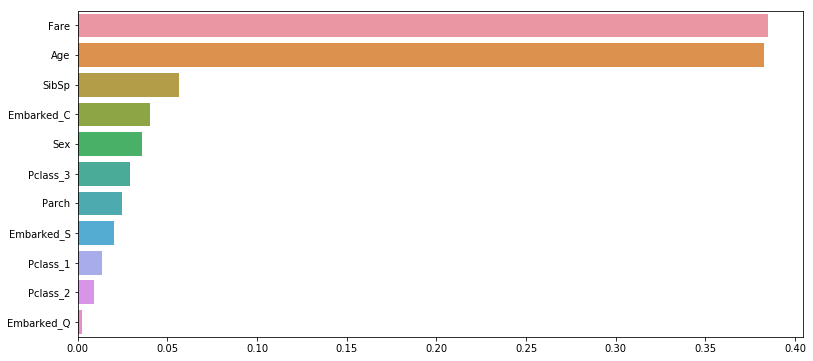

In [4]:
feature_names = training_set.columns[training_set.columns != "Survived"]
feature_importance = model.feature_importances_
index = np.argsort(feature_importance)
index = np.flip(index, axis = 0)

sns.barplot(y = feature_names[index], 
            x = feature_importance[index]);

But now we can go much further!!

First of all, we can re-calculate the feature importance. We can do it in three different ways:

1. Calculating the gain in each split due to each feature. This is the "best way" to do it in tree-based models:

In [5]:
booster = model.get_booster()
eli5.show_weights(estimator = booster, importance_type = "gain")

Weight,Feature
0.5424,Sex
0.1943,Pclass_3
0.0741,Pclass_1
0.0419,SibSp
0.0320,Embarked_Q
0.0258,Embarked_S
0.0245,Pclass_2
0.0237,Fare
0.0217,Age
0.0120,Parch


As you can see, results are very different from what the model says. That's because it is using another method: the "weight" method, the number of times a feature is used to split the data. We can also perform that calculation with **ELI5**:

In [6]:
eli5.show_weights(estimator = booster, importance_type = "weight")

Weight,Feature
0.3851,Fare
0.3829,Age
0.0563,SibSp
0.0405,Embarked_C
0.0360,Sex
0.0293,Pclass_3
0.0248,Parch
0.0203,Embarked_S
0.0135,Pclass_1
0.0090,Pclass_2


As you see, results are the same.

The problem with this method is that some splits are very relevant, and others aren't. And we are not making distinctions here. That's bad!

There is a third way to perform this calculation: the "cover" way, the average coverage of the feature:

In [7]:
eli5.show_weights(estimator = booster, importance_type = "cover")

Weight,Feature
0.2950,Sex
0.1736,Pclass_1
0.1142,Pclass_3
0.1080,Pclass_2
0.0664,Embarked_C
0.0651,SibSp
0.0543,Fare
0.0510,Age
0.0297,Embarked_S
0.0241,Parch


I recommend using always the first method ("gain").

### Explaining particular predictions

But now we can go much further!! We are able to explain why the XGBoost model made a particular prediction.

In [8]:
eli5.show_prediction(estimator = booster, 
                     doc = test_set.drop(columns="Survived").iloc[0,:])

So, the model says the passenger died, and we have a clear explanation here. Let's see the passenger's features:

In [9]:
test_set.iloc[0,:]

Sex            1.0000
Age           34.5000
SibSp          0.0000
Parch          0.0000
Fare           7.8292
Survived       0.0000
Pclass_1       0.0000
Pclass_2       0.0000
Pclass_3       1.0000
Embarked_C     0.0000
Embarked_Q     1.0000
Embarked_S     0.0000
Name: 0, dtype: float64

Contribution means how much each feature contributed to the final prediction across all trees. The idea for weight calculation is described in http://blog.datadive.net/interpreting-random-forests/

The main reason why the model says the passenger died is because he is a man. After that, his age (he is neither a child nor too young), and the Fair he paid (quite cheap, mean ticket fare = 33.28) are the main reasons of the prediction. As we see, the model gets it right.

Another interesting thing to note is the BIAS. As most of the passegers died, there is an intercept of sigmoid(-0.589), equivalent to a 0.36 probability of surviving. So, for a passenger whom we know nothing about, the best estimate we can make is that his probability of surviving is 0.36.

## Global interpretability

We are also able to explore the effect of any variable in the influence of other. Let's try this with the Age variable:

In [10]:
age_exp = eli5.explain_prediction(estimator = booster, 
                                  doc = test_set.drop(columns="Survived").iloc[0,:])

IndexError: tuple index out of range

The project is not very mature and there are some problems with the last version of XGBoost. 

### Additional resources

There is an interesting example using passenger names, also with XGBoost and ELI5, in the [oficial Github repo](https://github.com/TeamHG-Memex/eli5/blob/master/notebooks/xgboost-titanic.ipynb).

Also, there is an interesting package ([ELIH](https://github.com/fvinas/elih)) to improve the way the explanations of ELI5 are shown.